## Fig S6: Recovering signals from information footprints under extreme mutation rates.

In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

# Find the transcription start site
df = pd.read_csv('../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
promoter[(-38+115):(-30+116)]

'GCTTTACAC'

In [5]:
promoter[(-15+115):(-5+116)]

'TCGTATGTTGT'

In [7]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [8]:
O1_1027_raw = np.load('../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Lowering mutation rate

In [9]:
n_NS = len(genome)
n_p = 5000
n_r = 15
ep_wt = -5
er_wt = -15

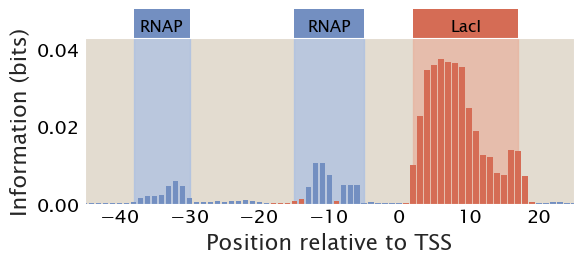

In [11]:
df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        mutrate=0.04)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile='../plots/figS6/weak_rnap.pdf')

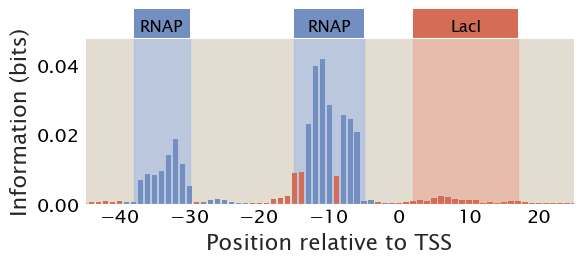

In [12]:
df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        mutrate=0.2)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile='../plots/figS6/strong_repressor_emat.pdf')

### Dependence on binding energies

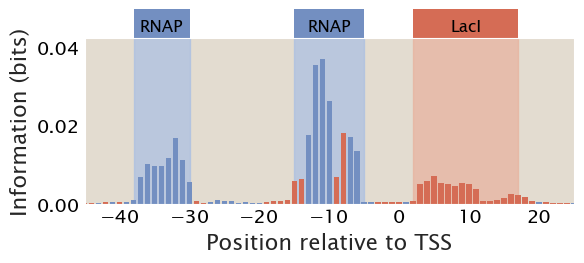

In [13]:
rep_emat_weak = rep_emat / 5

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat_weak, ep_wt, er_wt],
                        mutrate=0.2)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile='../plots/figS6/weak_repressor_emat.pdf')

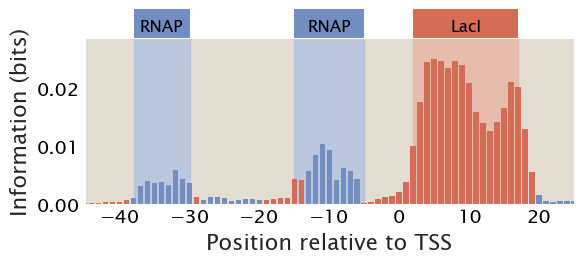

In [14]:
ep_wt_strong = -12
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt_strong, er_wt],
                        mutrate=0.04)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile='../plots/figS6/strong_rnap.pdf')